In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-scans/pituitary/0664.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1269.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0733.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0106.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0375.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1700.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1075.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0285.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0591.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0799.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1411.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0074.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1031.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0077.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0498.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1749.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/0610.jpg
/kaggle/input/brain-tumor-mri-scans/pituitary/1501.jpg
/kaggle/in

In [2]:
# CELL 1
import os, random, json, copy
from collections import OrderedDict, defaultdict
import numpy as np
import torch, torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score

# Globals (same as your original)
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLIENTS = 6
DIRICHLET_ALPHA = 0.15  # kept from your original code
ROUNDS = 30
LOCAL_EPOCHS = 2
BATCH_SIZE = 16
IMAGE_SIZE = 224
ROOT = "/kaggle/input/brain-tumor-mri-scans"  # change if your dataset path differs

DELAY_PROB = 0.15
FEDBUFF_APPLY_MULT = 0.6
Q_VAL = 0.2

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.makedirs("/kaggle/working/logs", exist_ok=True)
print("Device:", DEVICE)


Device: cuda


In [3]:
# CELL 2
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.samples = []
        for c in self.classes:
            folder = os.path.join(root_dir, c)
            for f in sorted(os.listdir(folder)):
                if f.lower().endswith(("png","jpg","jpeg","tif","tiff")):
                    self.samples.append((os.path.join(folder, f), self.class_to_idx[c]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, lbl

transform_train = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_eval = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# quick instantiate to validate path (no transforms)
full_dataset = BrainTumorDataset(ROOT, transform=None)
print("Found classes:", full_dataset.classes)
print("Total images:", len(full_dataset))


Found classes: ['glioma', 'healthy', 'meningioma', 'pituitary']
Total images: 7023


In [4]:
# CELL 3
num_total = len(full_dataset)
indices = np.arange(num_total)
np.random.seed(SEED)
np.random.shuffle(indices)

train_frac = 0.80
val_frac = 0.10
n_train = int(train_frac * num_total)
n_val = int(val_frac * num_total)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

central_val_loader = DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), val_idx),
                                batch_size=BATCH_SIZE, shuffle=False)
central_test_loader = DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), test_idx),
                                 batch_size=BATCH_SIZE, shuffle=False)

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")


Split sizes -> train: 5618, val: 702, test: 703


In [5]:
# CELL 4
def create_dirichlet_split_from_indices(dataset, indices_pool, num_clients, alpha, min_size=30):
    idx_by_class = defaultdict(list)
    for idx in indices_pool:
        _, y = dataset.samples[idx]
        idx_by_class[y].append(idx)

    client_map = {i: [] for i in range(num_clients)}

    for cls, idxs in idx_by_class.items():
        idxs = idxs.copy()
        np.random.shuffle(idxs)
        props = np.random.dirichlet([alpha] * num_clients)
        props = props / props.sum()
        counts = (props * len(idxs)).astype(int)
        counts[-1] = len(idxs) - counts[:-1].sum()
        ptr = 0
        for i in range(num_clients):
            client_map[i].extend(idxs[ptr:ptr+counts[i]])
            ptr += counts[i]

    # ensure min samples
    small = [c for c in client_map if len(client_map[c]) < min_size]
    big = [c for c in client_map if len(client_map[c]) >= min_size]

    leftover = []
    for c in small:
        leftover.extend(client_map[c])
        client_map[c] = []

    if leftover and len(big) > 0:
        np.random.shuffle(leftover)
        share = len(leftover) // len(big)
        for i, c in enumerate(big):
            s = i * share
            e = s + share if i < len(big)-1 else len(leftover)
            client_map[c].extend(leftover[s:e])

    return client_map

client_map = create_dirichlet_split_from_indices(full_dataset, train_idx, NUM_CLIENTS, DIRICHLET_ALPHA, min_size=30)

# JSON-safe dump (convert numpy ints to python ints)
safe_map = {str(k): [int(x) for x in v] for k, v in client_map.items()}
with open('/kaggle/working/logs/client_map.json', 'w') as f:
    json.dump(safe_map, f)

print("Client map created. Per-client counts:")
for k in client_map:
    print(k, len(client_map[k]))

Client map created. Per-client counts:
0 1130
1 87
2 819
3 1348
4 2103
5 131


In [6]:
# CELL 5
client_loaders = {}
for cid, idxs in client_map.items():
    idxs_sh = idxs.copy()
    np.random.seed(SEED + cid)
    np.random.shuffle(idxs_sh)
    n_local_train = int(0.85 * len(idxs_sh))
    tr_idx = idxs_sh[:n_local_train]
    vl_idx = idxs_sh[n_local_train:]
    client_loaders[cid] = {
        "train": DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_train), tr_idx),
                            batch_size=BATCH_SIZE, shuffle=True,
                            generator=torch.Generator().manual_seed(SEED + cid)),
        "val": DataLoader(Subset(BrainTumorDataset(ROOT, transform=transform_eval), vl_idx),
                          batch_size=BATCH_SIZE, shuffle=False)
    }
print("Built client loaders.")


Built client loaders.


In [7]:
# CELL 6
class SimpleEffNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_f = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
        n_freeze = int(0.7 * len(list(self.backbone.features.parameters())))
        for i, p in enumerate(self.backbone.features.parameters()):
            if i < n_freeze:
                p.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

def local_train(global_model, loader, epochs, use_fedprox=False, mu=0.08, lr=1e-3):
    if len(loader.dataset) == 0:
        return copy.deepcopy(global_model), 0.0

    model = copy.deepcopy(global_model).to(DEVICE)
    model.train()
    opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1, epochs))
    loss_fn = nn.CrossEntropyLoss()
    g_params = [p.detach().clone() for p in global_model.parameters()]

    losses = []
    for ep in range(epochs):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            if use_fedprox:
                prox = 0.0
                for lp, gp in zip(model.parameters(), g_params):
                    prox = prox + torch.norm(lp - gp.to(lp.device))**2
                loss = loss + (mu / 2.0) * prox
            loss.backward()
            torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
            opt.step()
            losses.append(float(loss.detach().cpu().numpy()))
        scheduler.step()

    avg_loss = float(np.mean(losses)) if losses else 0.0
    return model, avg_loss

def fedavg_aggregate(global_model, client_models, weights=None):
    g_state = global_model.state_dict()
    new_state = OrderedDict()
    if weights is None:
        weights = [1.0/len(client_models)] * len(client_models)
    for k in g_state:
        if g_state[k].dtype == torch.int64:
            new_state[k] = g_state[k].clone()
            continue
        accum = None
        for i, cm in enumerate(client_models):
            val = cm.state_dict()[k].float().to(g_state[k].device)
            w = weights[i]
            accum = val * w if accum is None else accum + val * w
        new_state[k] = accum.type_as(g_state[k])
    return new_state

class FedBuff:
    def __init__(self):
        self.buffer = []
    def add(self, state, samples, rnd):
        self.buffer.append({"state": {k:v.clone().cpu() for k,v in state.items()}, "samples": samples, "round": rnd})
    def apply(self, current_state, cur_round, apply_prob=0.4, max_age=8, apply_mult=FEDBUFF_APPLY_MULT):
        new_state = OrderedDict((k, v.clone()) for k,v in current_state.items())
        self.buffer = [b for b in self.buffer if (cur_round - b["round"]) <= max_age]
        apply_indices = [i for i in range(len(self.buffer)) if random.random() < apply_prob]
        for idx in sorted(apply_indices, reverse=True):
            b = self.buffer[idx]
            for k in new_state:
                if new_state[k].dtype != torch.int64:
                    delta = b["state"][k].to(new_state[k].device) - new_state[k]
                    new_state[k] = new_state[k] + apply_mult * delta
            del self.buffer[idx]
        return new_state

def compute_q_weights(losses, samples, q=Q_VAL, eps=1e-8):
    w = []
    for i in range(len(samples)):
        L = max(losses[i], eps)
        w.append(samples[i] * ((L + eps) ** q))
    s = sum(w)
    if s <= 0:
        return [s_i / sum(samples) for s_i in samples]
    return [wi / s for wi in w]

def evaluate(model, loader):
    if len(loader.dataset) == 0:
        return 0,0,0,0
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            p = model(xb).argmax(1)
            preds.extend(p.cpu().numpy().tolist())
            labels.extend(yb.cpu().numpy().tolist())
    preds = np.array(preds); labels = np.array(labels)
    acc = 100 * np.mean(preds == labels)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)
    return acc, prec, rec, f1

def print_summary(r, stats):
    print(f"""
================ ROUND {r} ================
Acc        : {stats['acc']:.2f}%
Precision  : {stats['prec']:.3f}
Recall     : {stats['rec']:.3f}
F1 Score   : {stats['f1']:.3f}
Fairness   : {stats['fairness']:.3f}
Avg Stale  : {stats['avg_stale']:.3f}
ClientLoss : {[round(x, 3) for x in stats['losses']]}
Active     : {stats['active']}
Delayed    : {stats['delayed']}
===========================================
""")


In [8]:
# CELL 7
print("Running FedAvg | DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
NUM_CLASSES = len(full_dataset.classes)
model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
log_data = []

for r in range(ROUNDS):
    active = list(client_loaders.keys())
    delayed = []
    client_models, client_losses, client_samples = [], [], []

    for cid in active:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS)
        client_models.append(lm)
        client_losses.append(loss)
        client_samples.append(len(client_loaders[cid]["train"].dataset))

    if client_models:
        w = [s / sum(client_samples) for s in client_samples]
        new_state = fedavg_aggregate(model, client_models, w)
        model.load_state_dict(new_state)

    gacc, prec, rec, f1 = evaluate(model, central_val_loader)
    fairness = float(np.std([evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]))

    stats = {"round": r, "acc": gacc, "prec": prec, "rec": rec, "f1": f1,
             "fairness": fairness, "avg_stale": 0, "losses": client_losses,
             "active": active, "delayed": delayed}
    print_summary(r, stats)
    log_data.append(stats)

save_path = f"/kaggle/working/logs/FedAvg_alpha_{DIRICHLET_ALPHA}.json"
with open(save_path, "w") as f: json.dump(log_data, f, indent=2)
torch.save(model.state_dict(), f"/kaggle/working/logs/FedAvg_alpha_{DIRICHLET_ALPHA}_final.pth")
print("FedAvg finished, model saved.")

Running FedAvg | DIRICHLET_ALPHA = 0.15


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]



================ ROUND 0 ================
Acc        : 42.45%
Precision  : 0.617
Recall     : 0.476
F1 Score   : 0.338
Fairness   : 39.998
Avg Stale  : 0.000
ClientLoss : [0.191, 0.312, 0.433, 0.238, 0.248, 0.852]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 1 ================
Acc        : 47.01%
Precision  : 0.749
Recall     : 0.521
F1 Score   : 0.400
Fairness   : 41.982
Avg Stale  : 0.000
ClientLoss : [0.152, 0.386, 0.285, 0.2, 0.173, 0.528]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 2 ================
Acc        : 50.00%
Precision  : 0.744
Recall     : 0.544
F1 Score   : 0.437
Fairness   : 42.266
Avg Stale  : 0.000
ClientLoss : [0.131, 0.267, 0.278, 0.161, 0.153, 0.612]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 3 ================
Acc        : 50.85%
Precision  : 0.756
Recall     : 0.556
F1 Score   : 0.455
Fairness   : 39.599
Avg Stale  : 0.000
ClientLoss : [0.128, 0.273, 0.193, 0.145, 0.144, 0.

In [9]:
# CELL 8
print("Running FedBuff | DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
buffer = FedBuff()
log_data = []
staleness = {cid: 0 for cid in client_map}

for r in range(ROUNDS):
    active, delayed = [], []
    for cid in client_loaders:
        if random.random() < 0.25:
            delayed.append(cid); staleness[cid] += 1
        else:
            active.append(cid); staleness[cid] = 0

    client_models, client_losses, client_samples = [], [], []
    for cid in active:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS)
        client_models.append(lm); client_losses.append(loss)
        client_samples.append(len(client_loaders[cid]["train"].dataset))

    for cid in delayed:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS)
        buffer.add(lm.state_dict(), len(client_loaders[cid]["train"].dataset), r)

    if client_models:
        w = [s / sum(client_samples) for s in client_samples]
        model.load_state_dict(fedavg_aggregate(model, client_models, w))

    model.load_state_dict(buffer.apply(model.state_dict(), cur_round=r))
    gacc, prec, rec, f1 = evaluate(model, central_val_loader)
    fairness = float(np.std([evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]))
    avg_stale = float(np.mean(list(staleness.values()))) if len(staleness)>0 else 0.0

    stats = {"round": r, "acc": gacc, "prec": prec, "rec": rec, "f1": f1,
             "fairness": fairness, "avg_stale": avg_stale, "losses": client_losses,
             "active": active, "delayed": delayed}
    print_summary(r, stats); log_data.append(stats)

with open(f"/kaggle/working/logs/FedBuff_alpha_{DIRICHLET_ALPHA}.json", "w") as f: json.dump(log_data, f, indent=2)
torch.save(model.state_dict(), f"/kaggle/working/logs/FedBuff_alpha_{DIRICHLET_ALPHA}_final.pth")
print("FedBuff finished, model saved.")


Running FedBuff | DIRICHLET_ALPHA = 0.15

================ ROUND 0 ================
Acc        : 46.58%
Precision  : 0.318
Recall     : 0.427
F1 Score   : 0.329
Fairness   : 34.769
Avg Stale  : 0.333
ClientLoss : [0.202, 0.368, 0.248, 0.83]
Active     : [0, 2, 4, 5]
Delayed    : [1, 3]


================ ROUND 1 ================
Acc        : 75.07%
Precision  : 0.765
Recall     : 0.739
F1 Score   : 0.659
Fairness   : 31.847
Avg Stale  : 0.833
ClientLoss : [0.197, 0.171]
Active     : [0, 3]
Delayed    : [1, 2, 4, 5]


================ ROUND 2 ================
Acc        : 31.91%
Precision  : 0.080
Recall     : 0.250
F1 Score   : 0.121
Fairness   : 42.578
Avg Stale  : 0.500
ClientLoss : [0.103, 0.287, 0.141, 0.705]
Active     : [1, 2, 3, 5]
Delayed    : [0, 4]


================ ROUND 3 ================
Acc        : 54.27%
Precision  : 0.427
Recall     : 0.598
F1 Score   : 0.483
Fairness   : 35.245
Avg Stale  : 0.000
ClientLoss : [0.356, 0.001, 0.388, 0.183, 0.291, 1.896]
Active     : [0

In [10]:
# CELL 9
print("Running QFedAvg + FedBuff | DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
buffer = FedBuff()
log_data = []
staleness = {cid: 0 for cid in client_map}

for r in range(ROUNDS):
    active, delayed = [], []
    for cid in client_loaders:
        if random.random() < DELAY_PROB:
            delayed.append(cid); staleness[cid] += 1
        else:
            active.append(cid); staleness[cid] = 0

    client_models, client_losses, client_samples = [], [], []
    for cid in active:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS, use_fedprox=False)
        client_models.append(lm); client_losses.append(loss)
        client_samples.append(len(client_loaders[cid]["train"].dataset))

    for cid in delayed:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS, use_fedprox=False)
        buffer.add(lm.state_dict(), len(client_loaders[cid]["train"].dataset), r)

    if len(client_models) > 0:
        q_weights = compute_q_weights(client_losses, client_samples, q=Q_VAL)
        model.load_state_dict(fedavg_aggregate(model, client_models, q_weights))

    model.load_state_dict(buffer.apply(model.state_dict(), cur_round=r, apply_prob=0.4, max_age=8, apply_mult=FEDBUFF_APPLY_MULT))

    gacc, prec, rec, f1 = evaluate(model, central_val_loader)
    accs = [evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]
    fairness = float(np.std(accs))
    avg_stale = float(np.mean(list(staleness.values())))

    stats = {"round": r, "acc": gacc, "prec": prec, "rec": rec, "f1": f1,
             "fairness": fairness, "avg_stale": avg_stale, "losses": client_losses,
             "active": active, "delayed": delayed}
    print_summary(r, stats); log_data.append(stats)

with open(f"/kaggle/working/logs/QFedAvg_FedBuff_ALPHA_{DIRICHLET_ALPHA}.json", "w") as f: json.dump(log_data, f, indent=2)
torch.save(model.state_dict(), f"/kaggle/working/logs/QFedAvg_FedBuff_ALPHA_{DIRICHLET_ALPHA}_final.pth")
print("QFedAvg+FedBuff finished, model saved.")


Running QFedAvg + FedBuff | DIRICHLET_ALPHA = 0.15

================ ROUND 0 ================
Acc        : 47.15%
Precision  : 0.482
Recall     : 0.527
F1 Score   : 0.405
Fairness   : 41.158
Avg Stale  : 0.333
ClientLoss : [0.241, 0.234, 0.228, 0.798]
Active     : [0, 3, 4, 5]
Delayed    : [1, 2]


================ ROUND 1 ================
Acc        : 72.36%
Precision  : 0.548
Recall     : 0.713
F1 Score   : 0.612
Fairness   : 33.169
Avg Stale  : 0.500
ClientLoss : [0.273, 0.202, 0.196, 0.629]
Active     : [2, 3, 4, 5]
Delayed    : [0, 1]


================ ROUND 2 ================
Acc        : 47.15%
Precision  : 0.741
Recall     : 0.518
F1 Score   : 0.369
Fairness   : 40.147
Avg Stale  : 0.000
ClientLoss : [0.197, 0.195, 0.267, 0.189, 0.177, 0.664]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 3 ================
Acc        : 48.29%
Precision  : 0.736
Recall     : 0.532
F1 Score   : 0.408
Fairness   : 41.999
Avg Stale  : 0.167
ClientLoss : [0.143, 0.446, 0.

In [11]:
# CELL 10
print("Running QFedAvg + FedBuff + FedProx | DIRICHLET_ALPHA =", DIRICHLET_ALPHA)
model = SimpleEffNet(num_classes=NUM_CLASSES).to(DEVICE)
buffer = FedBuff()
log_data = []
staleness = {cid: 0 for cid in client_map}

for r in range(ROUNDS):
    active, delayed = [], []
    for cid in client_loaders:
        if random.random() < DELAY_PROB:
            delayed.append(cid); staleness[cid] += 1
        else:
            active.append(cid); staleness[cid] = 0

    client_models, client_losses, client_samples = [], [], []
    for cid in active:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS, use_fedprox=True, mu=0.08)
        client_models.append(lm); client_losses.append(loss)
        client_samples.append(len(client_loaders[cid]["train"].dataset))

    for cid in delayed:
        lm, loss = local_train(model, client_loaders[cid]["train"], LOCAL_EPOCHS, use_fedprox=True, mu=0.08)
        buffer.add(lm.state_dict(), len(client_loaders[cid]["train"].dataset), r)

    if len(client_models) > 0:
        q_weights = compute_q_weights(client_losses, client_samples, q=Q_VAL)
        model.load_state_dict(fedavg_aggregate(model, client_models, q_weights))

    model.load_state_dict(buffer.apply(model.state_dict(), cur_round=r, apply_prob=0.4, max_age=8, apply_mult=FEDBUFF_APPLY_MULT))

    gacc, prec, rec, f1 = evaluate(model, central_val_loader)
    accs = [evaluate(model, client_loaders[c]["val"])[0] for c in client_loaders]
    fairness = float(np.std(accs)) if len(accs) else 0.0
    avg_stale = float(np.mean(list(staleness.values()))) if len(staleness)>0 else 0.0

    stats = {"round": r, "acc": gacc, "prec": prec, "rec": rec, "f1": f1,
             "fairness": fairness, "avg_stale": avg_stale, "losses": client_losses,
             "active": active, "delayed": delayed}
    print_summary(r, stats); log_data.append(stats)

with open(f"/kaggle/working/logs/QFedAvg_FedBuff_FedProx_ALPHA_{DIRICHLET_ALPHA}.json", "w") as f: json.dump(log_data, f, indent=2)
torch.save(model.state_dict(), f"/kaggle/working/logs/QFedAvg_FedBuff_FedProx_ALPHA_{DIRICHLET_ALPHA}_final.pth")
print("QFedAvg+FedBuff+FedProx finished, model saved.")


Running QFedAvg + FedBuff + FedProx | DIRICHLET_ALPHA = 0.15

================ ROUND 0 ================
Acc        : 43.45%
Precision  : 0.226
Recall     : 0.487
F1 Score   : 0.305
Fairness   : 42.997
Avg Stale  : 0.167
ClientLoss : [0.482, 0.675, 1.169, 0.893, 1.573]
Active     : [0, 1, 2, 3, 5]
Delayed    : [4]


================ ROUND 1 ================
Acc        : 51.14%
Precision  : 0.498
Recall     : 0.547
F1 Score   : 0.422
Fairness   : 37.366
Avg Stale  : 0.000
ClientLoss : [0.469, 0.821, 1.144, 0.795, 0.768, 1.392]
Active     : [0, 1, 2, 3, 4, 5]
Delayed    : []


================ ROUND 2 ================
Acc        : 72.36%
Precision  : 0.559
Recall     : 0.714
F1 Score   : 0.616
Fairness   : 32.875
Avg Stale  : 0.333
ClientLoss : [0.386, 0.647, 0.678, 0.671]
Active     : [0, 1, 3, 4]
Delayed    : [2, 5]


================ ROUND 3 ================
Acc        : 84.19%
Precision  : 0.851
Recall     : 0.828
F1 Score   : 0.834
Fairness   : 8.523
Avg Stale  : 0.167
ClientLoss : [

In [12]:
# CELL 11
print("Final evaluation on central TEST set for saved models:")

paths = {
    "FedAvg": f"/kaggle/working/logs/FedAvg_alpha_{DIRICHLET_ALPHA}_final.pth",
    "FedBuff": f"/kaggle/working/logs/FedBuff_alpha_{DIRICHLET_ALPHA}_final.pth",
    "QFedAvg+FedBuff": f"/kaggle/working/logs/QFedAvg_FedBuff_ALPHA_{DIRICHLET_ALPHA}_final.pth",
    "QFedAvg+FedBuff+FedProx": f"/kaggle/working/logs/QFedAvg_FedBuff_FedProx_ALPHA_{DIRICHLET_ALPHA}_final.pth"
}

for name, p in paths.items():
    if os.path.exists(p):
        m = SimpleEffNet(num_classes=len(full_dataset.classes)).to(DEVICE)
        m.load_state_dict(torch.load(p, map_location=DEVICE))
        acc, prec, rec, f1 = evaluate(m, central_test_loader)
        print(f"{name}: TEST acc={acc:.2f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
    else:
        print(f"{name}: model file not found at {p}")

# Optional: zip logs for download
import shutil
shutil.make_archive("/kaggle/working/dtfl_logs", 'zip', "/kaggle/working/logs")
print("Logs & models zipped to /kaggle/working/dtfl_logs.zip (check Output files to download).")


Final evaluation on central TEST set for saved models:
FedAvg: TEST acc=86.91, prec=0.878, rec=0.869, f1=0.861
FedBuff: TEST acc=80.65, prec=0.854, rec=0.790, f1=0.741
QFedAvg+FedBuff: TEST acc=92.18, prec=0.916, rec=0.919, f1=0.917
QFedAvg+FedBuff+FedProx: TEST acc=89.62, prec=0.896, rec=0.888, f1=0.883
Logs & models zipped to /kaggle/working/dtfl_logs.zip (check Output files to download).


In [2]:
import json
import os

BASE = "/kaggle/input/dtfl-alpha0-13"
json_files = [f for f in os.listdir(BASE) if f.endswith(".json")]

all_methods = {}

for jf in json_files:
    path = os.path.join(BASE, jf)
    try:
        with open(path, "r") as f:
            data = json.load(f)
        
        # If data is a dict with a single key pointing to list, unwrap it
        if isinstance(data, dict) and len(data)==1 and isinstance(list(data.values())[0], list):
            data = list(data.values())[0]
        
        # Now data should be a list of dicts
        if isinstance(data, list) and all(isinstance(d, dict) for d in data):
            rounds = [d.get("round") for d in data]
            acc = [d.get("acc") for d in data]
            prec = [d.get("prec") for d in data]
            rec = [d.get("rec") for d in data]
            f1 = [d.get("f1") for d in data]
            fairness = [d.get("fairness") for d in data]
            avg_stale = [d.get("avg_stale") for d in data]
            losses = [d.get("losses") for d in data]  # list of lists
            
            all_methods[jf.replace(".json","")] = {
                "rounds": rounds,
                "acc": acc,
                "prec": prec,
                "rec": rec,
                "f1": f1,
                "fairness": fairness,
                "avg_stale": avg_stale,
                "losses": losses
            }
        else:
            print("Skipping JSON (bad format):", jf)
    except Exception as e:
        print("Error loading", jf, "->", e)

print("Loaded methods:", list(all_methods.keys()))


Loaded methods: []


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for method, d in all_methods.items():
    # 1️⃣ Metrics vs Rounds
    plt.figure(figsize=(12,6))
    plt.plot(d["rounds"], d["acc"], marker='o', label="Accuracy")
    plt.plot(d["rounds"], d["f1"], marker='x', label="F1 Score")
    plt.plot(d["rounds"], d["prec"], marker='^', label="Precision")
    plt.plot(d["rounds"], d["rec"], marker='s', label="Recall")
    plt.xlabel("Round")
    plt.ylabel("Metric Value")
    plt.title(f"Metrics per Round - {method}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2️⃣ Fairness vs Round
    plt.figure(figsize=(10,4))
    plt.plot(d["rounds"], d["fairness"], marker='o', color='purple')
    plt.xlabel("Round")
    plt.ylabel("Fairness")
    plt.title(f"Fairness per Round - {method}")
    plt.grid(True)
    plt.show()
    
    # 3️⃣ Average Staleness vs Round
    plt.figure(figsize=(10,4))
    plt.plot(d["rounds"], d["avg_stale"], marker='o', color='orange')
    plt.xlabel("Round")
    plt.ylabel("Avg Staleness")
    plt.title(f"Average Staleness per Round - {method}")
    plt.grid(True)
    plt.show()
    
    # 4️⃣ Client Loss heatmap (with padding for unequal lengths)
    max_clients = max(len(cl) for cl in d["losses"])
    padded_losses = [cl + [np.nan]*(max_clients - len(cl)) for cl in d["losses"]]
    loss_matrix = np.array(padded_losses)
    
    plt.figure(figsize=(10,6))
    plt.imshow(loss_matrix, cmap='viridis', aspect='auto', interpolation='none')
    plt.colorbar(label="Client Loss")
    plt.xlabel("Client")
    plt.ylabel("Round")
    plt.title(f"Client Loss per Round - {method}")
    plt.show()

    # 5️⃣ Global Loss per Round
    avg_loss_per_round = [np.mean(cl) for cl in d["losses"]]
    plt.figure(figsize=(10,5))
    plt.plot(d["rounds"], avg_loss_per_round, marker='o', color='red')
    plt.xlabel("Round")
    plt.ylabel("Average Client Loss")
    plt.title(f"Average Loss per Round - {method}")
    plt.grid(True)
    plt.show()


Loaded methods: ['QFEDAVG_FEDBUFF_ALPHA_0.15', 'QFEDAVG_FEDBUFF_FEDPROX_ALPHA_0.15', 'FEDBUFF_ALPHA_0.15', 'FEDAVG_ALPHA_0.15']

=== SANITY CHECK: QFEDAVG_FEDBUFF_ALPHA_0.15 ===
[WARNING] acc out of bounds for QFEDAVG_FEDBUFF_ALPHA_0.15
QFEDAVG_FEDBUFF_ALPHA_0.15 - acc: min=44.160, max=90.456, mean=69.734
QFEDAVG_FEDBUFF_ALPHA_0.15 - prec: min=0.249, max=0.897, mean=0.770
QFEDAVG_FEDBUFF_ALPHA_0.15 - rec: min=0.424, max=0.900, mean=0.702
QFEDAVG_FEDBUFF_ALPHA_0.15 - f1: min=0.321, max=0.898, mean=0.645
[WARNING] fairness out of bounds for QFEDAVG_FEDBUFF_ALPHA_0.15
QFEDAVG_FEDBUFF_ALPHA_0.15 - fairness: min=7.326, max=43.339, mean=27.307
QFEDAVG_FEDBUFF_ALPHA_0.15 - avg_stale: min=0.000, max=0.500, mean=0.156

=== SANITY CHECK: QFEDAVG_FEDBUFF_FEDPROX_ALPHA_0.15 ===
[WARNING] acc out of bounds for QFEDAVG_FEDBUFF_FEDPROX_ALPHA_0.15
QFEDAVG_FEDBUFF_FEDPROX_ALPHA_0.15 - acc: min=43.447, max=89.459, mean=73.020
QFEDAVG_FEDBUFF_FEDPROX_ALPHA_0.15 - prec: min=0.226, max=0.894, mean=0.762
QF

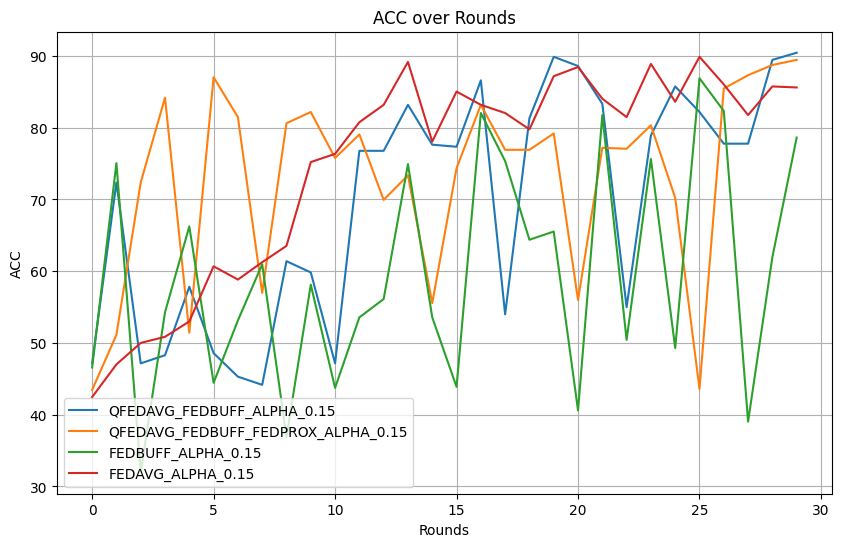

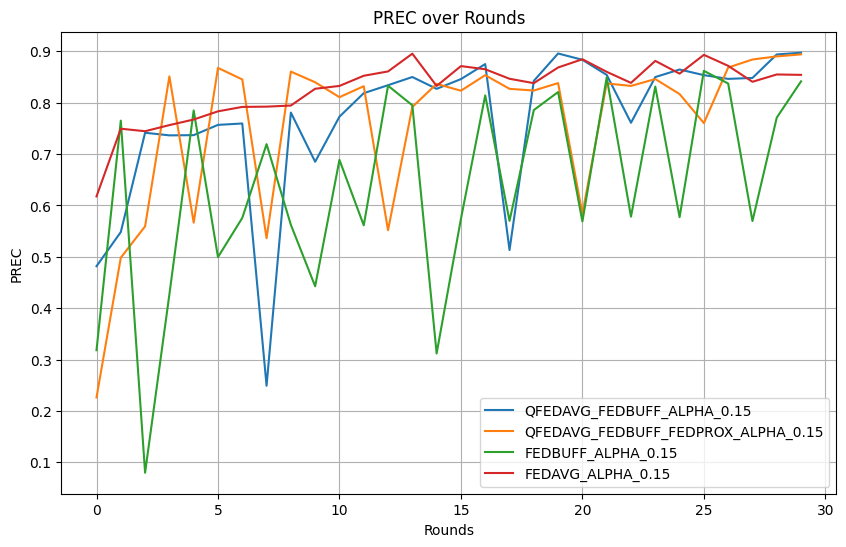

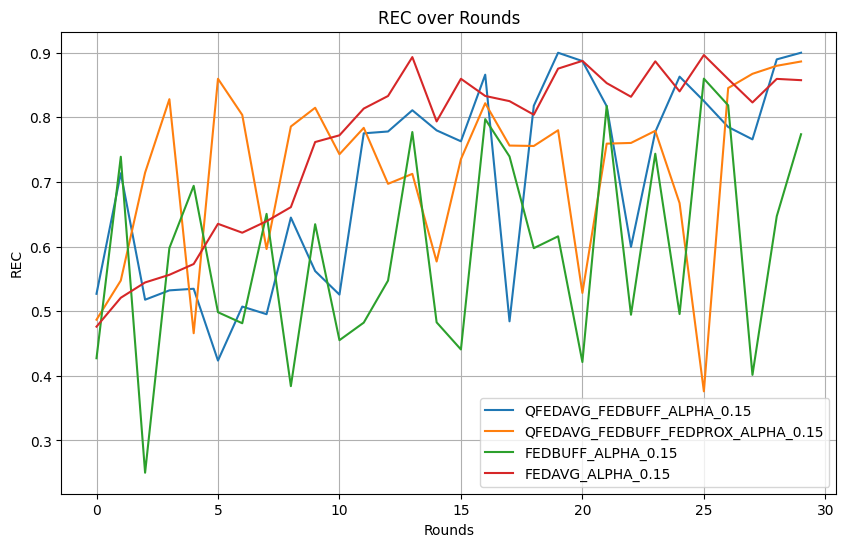

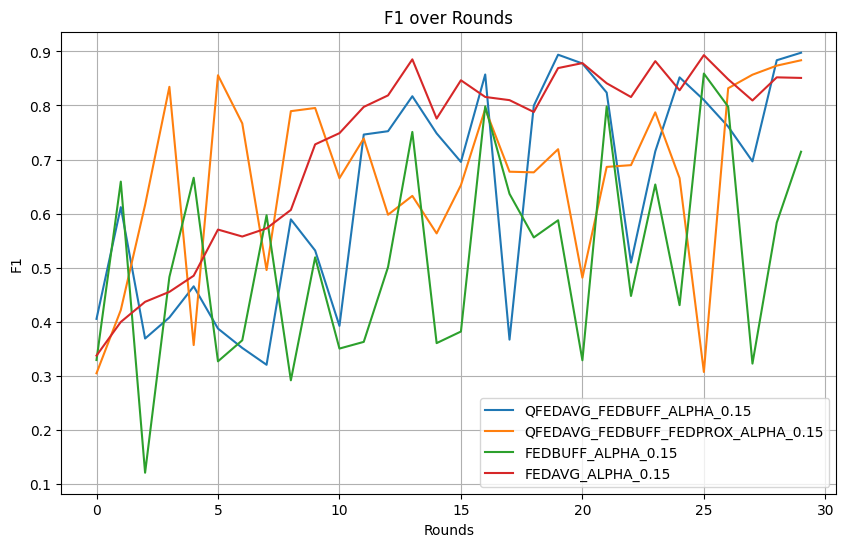

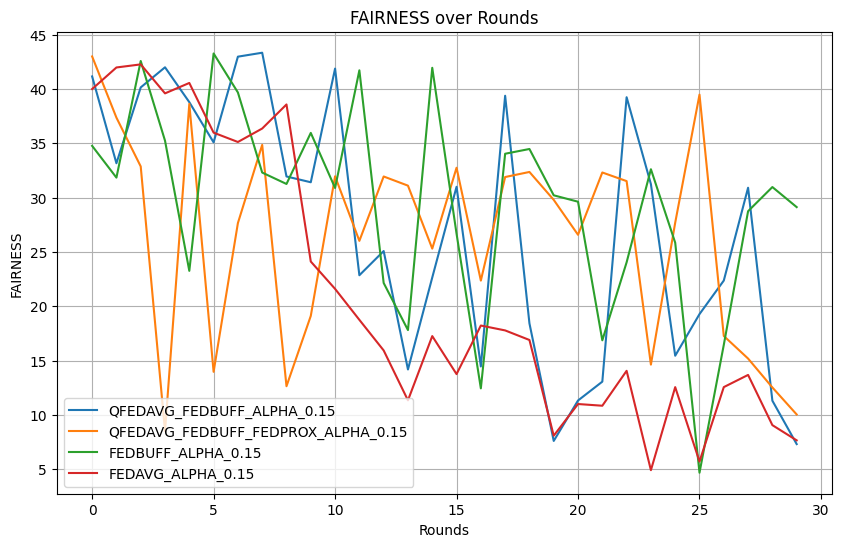

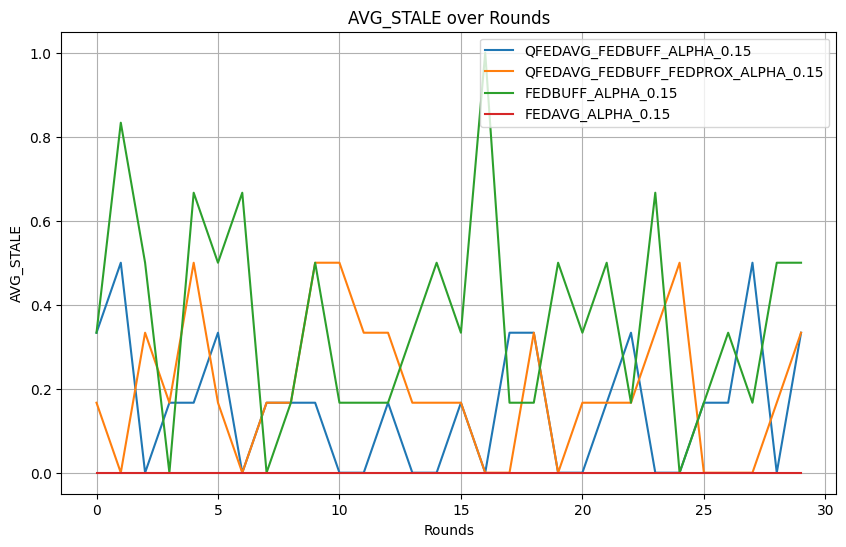

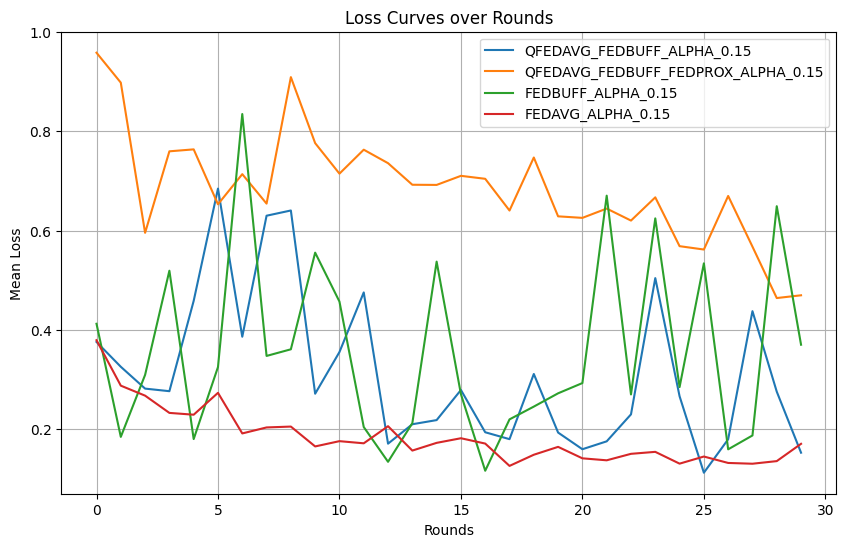

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load JSONs
# ------------------------------
BASE = "/kaggle/input/dtfl-alpha0-15"  # Change if needed
json_files = [f for f in os.listdir(BASE) if f.endswith(".json")]

all_methods = {}

for jf in json_files:
    path = os.path.join(BASE, jf)
    try:
        with open(path, "r") as f:
            data = json.load(f)
        
        if isinstance(data, dict) and len(data)==1 and isinstance(list(data.values())[0], list):
            data = list(data.values())[0]
        
        if isinstance(data, list) and all(isinstance(d, dict) for d in data):
            rounds = [d.get("round", None) for d in data]
            acc = [d.get("acc", None) for d in data]
            prec = [d.get("prec", None) for d in data]
            rec = [d.get("rec", None) for d in data]
            f1 = [d.get("f1", None) for d in data]
            fairness = [d.get("fairness", None) for d in data]
            avg_stale = [d.get("avg_stale", None) for d in data]
            losses = [d.get("losses", None) for d in data]
            
            method_name = jf.replace(".json","").upper()
            all_methods[method_name] = {
                "rounds": rounds,
                "acc": acc,
                "prec": prec,
                "rec": rec,
                "f1": f1,
                "fairness": fairness,
                "avg_stale": avg_stale,
                "losses": losses
            }
        else:
            print("Skipping JSON (bad format):", jf)
    except Exception as e:
        print("Error loading", jf, "->", e)

print("Loaded methods:", list(all_methods.keys()))

# ------------------------------
# 2. Sanity Checks
# ------------------------------
def sanity_check(metric, name, method):
    metric_np = np.array(metric)
    if np.any(metric_np < 0) or np.any(metric_np > 1):
        print(f"[WARNING] {name} out of bounds for {method}")
    print(f"{method} - {name}: min={np.nanmin(metric_np):.3f}, max={np.nanmax(metric_np):.3f}, mean={np.nanmean(metric_np):.3f}")

for method, metrics in all_methods.items():
    print(f"\n=== SANITY CHECK: {method} ===")
    for m_name in ["acc", "prec", "rec", "f1", "fairness", "avg_stale"]:
        if metrics[m_name][0] is not None:
            sanity_check(metrics[m_name], m_name, method)

# ------------------------------
# 3. Plot Metrics over Rounds
# ------------------------------
def plot_metric(metric_name, ylabel, methods=all_methods):
    plt.figure(figsize=(10,6))
    for method, metrics in methods.items():
        rounds = metrics["rounds"]
        values = metrics[metric_name]
        if values[0] is not None:
            plt.plot(rounds, values, label=method)
    plt.xlabel("Rounds")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} over Rounds")
    plt.legend()
    plt.grid(True)
    plt.show()

for m in ["acc", "prec", "rec", "f1", "fairness", "avg_stale"]:
    plot_metric(m, m.upper())

# ------------------------------
# 4. Plot Loss Curves
# ------------------------------
plt.figure(figsize=(10,6))
for method, metrics in all_methods.items():
    all_losses = metrics["losses"]
    if all_losses[0] is not None:
        # Flatten loss per round (if stored as list of client losses)
        mean_loss = [np.mean(l) if l is not None else None for l in all_losses]
        plt.plot(metrics["rounds"], mean_loss, label=method)
plt.xlabel("Rounds")
plt.ylabel("Mean Loss")
plt.title("Loss Curves over Rounds")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# 5. Optional: Check for Missing Values
# ------------------------------
for method, metrics in all_methods.items():
    for key, vals in metrics.items():
        if any(v is None for v in vals):
            print(f"[MISSING DATA] {method} - {key} has missing values.")


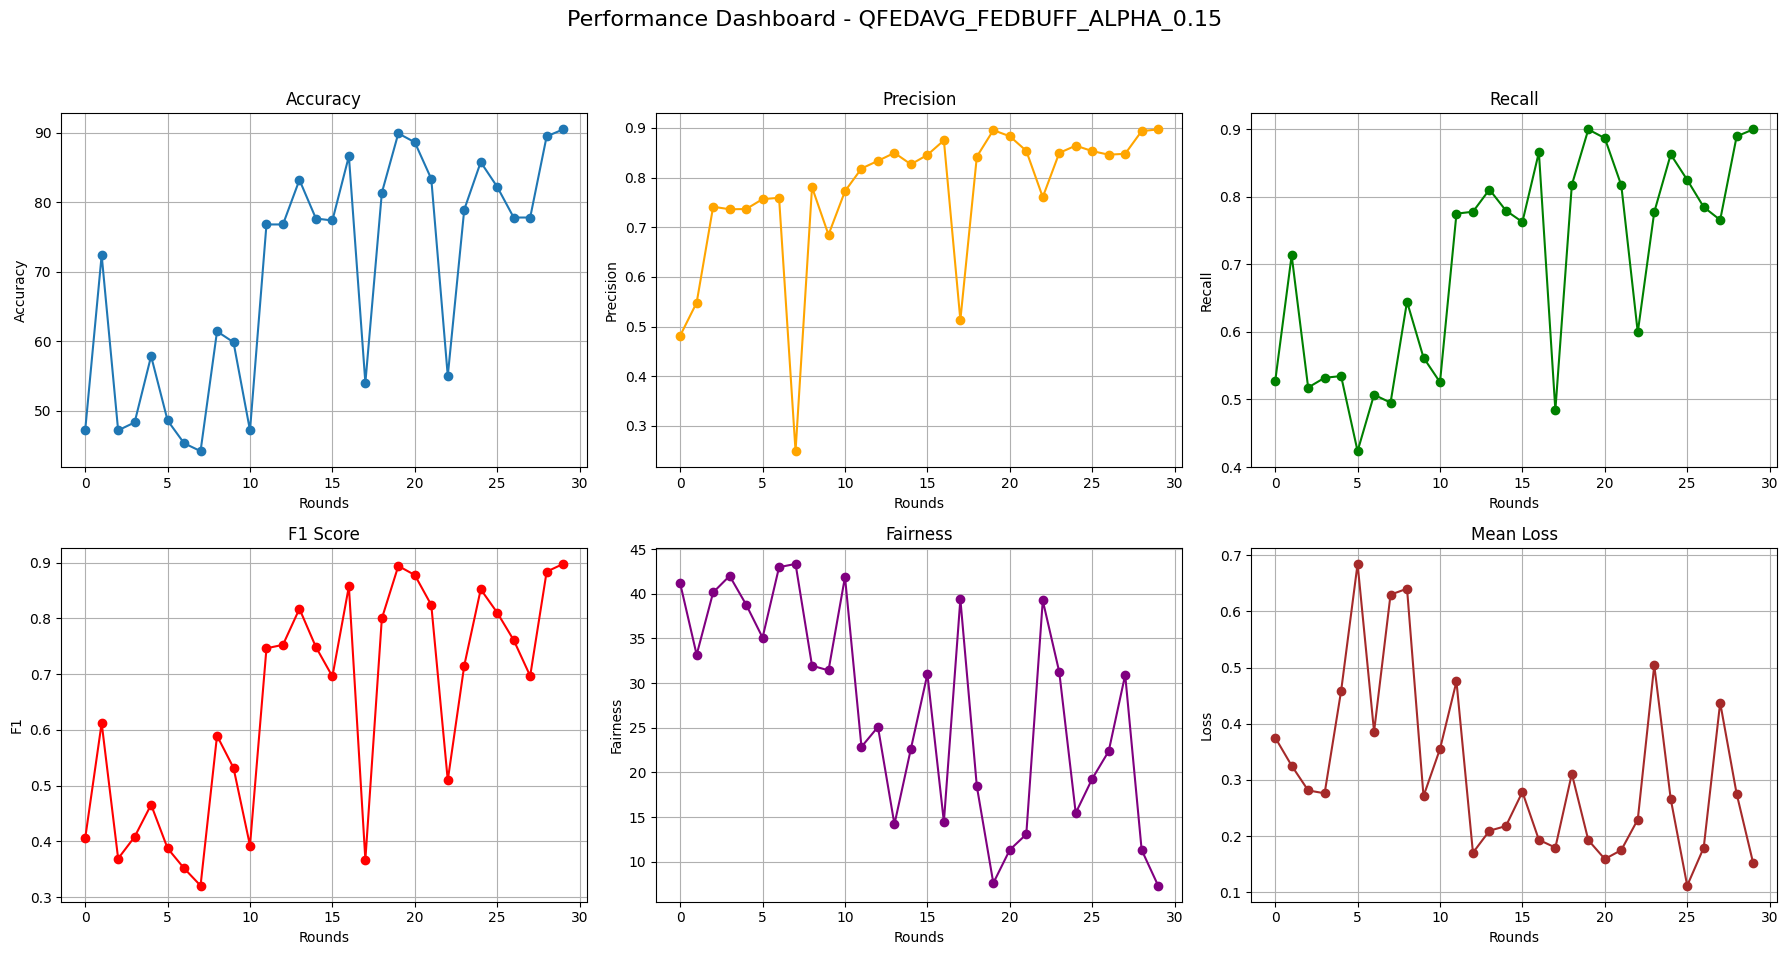

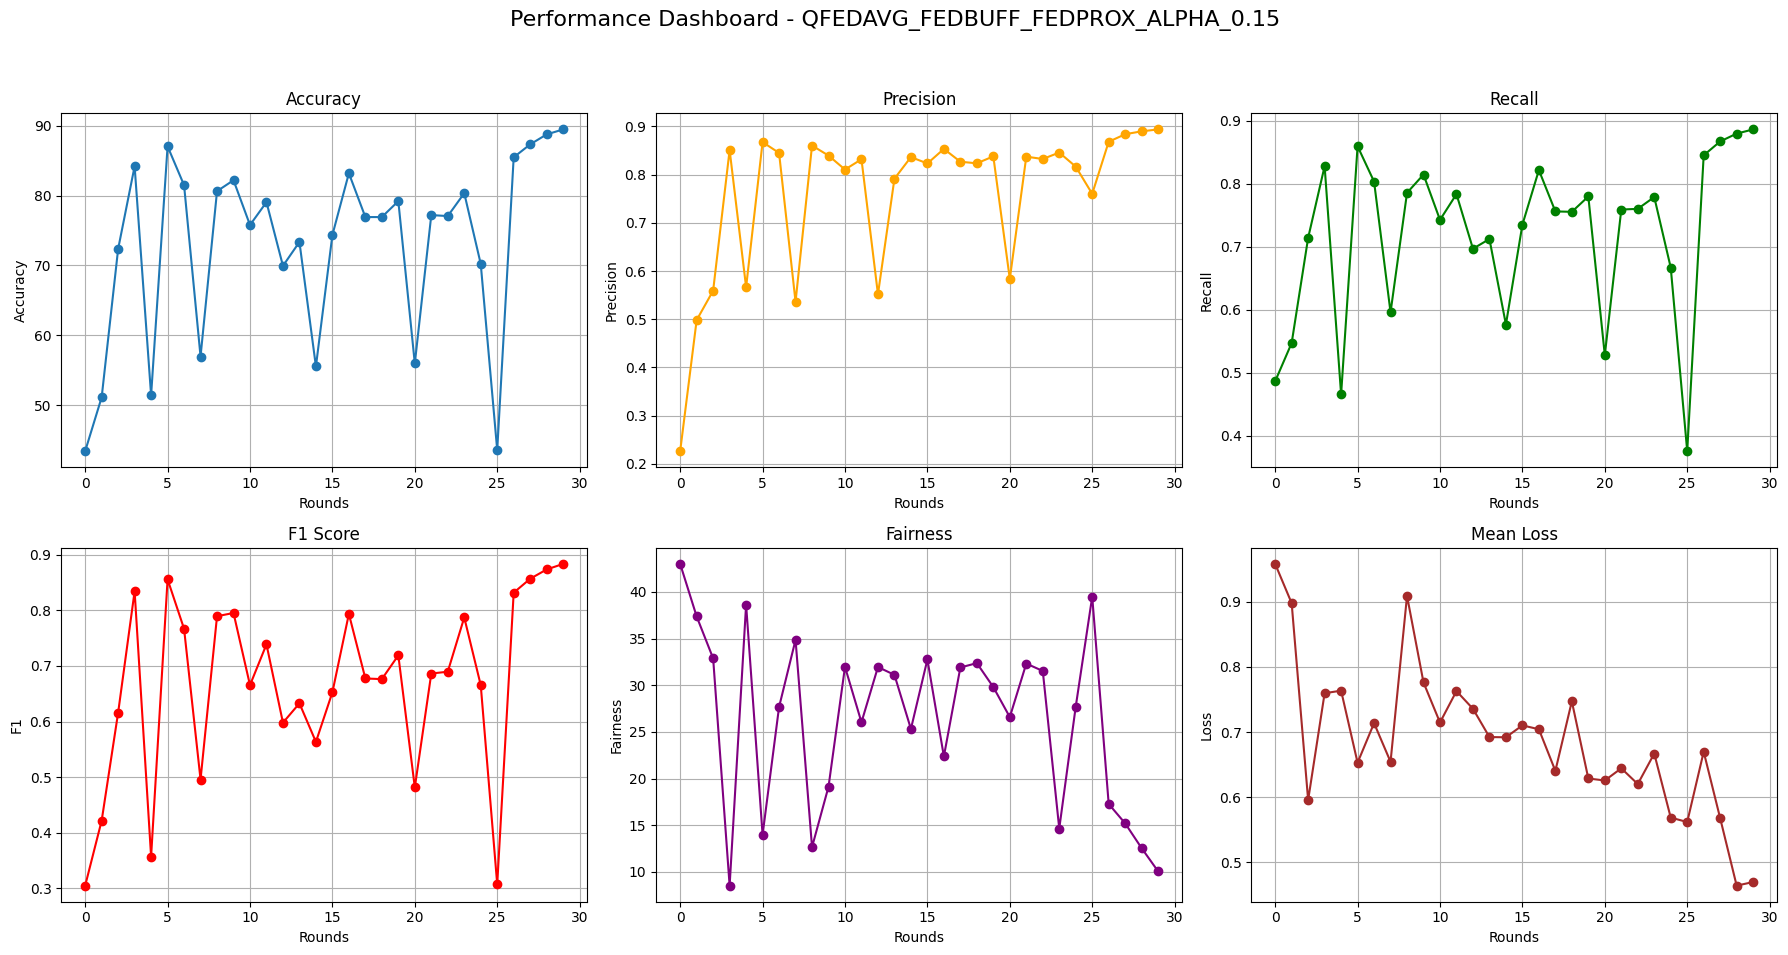

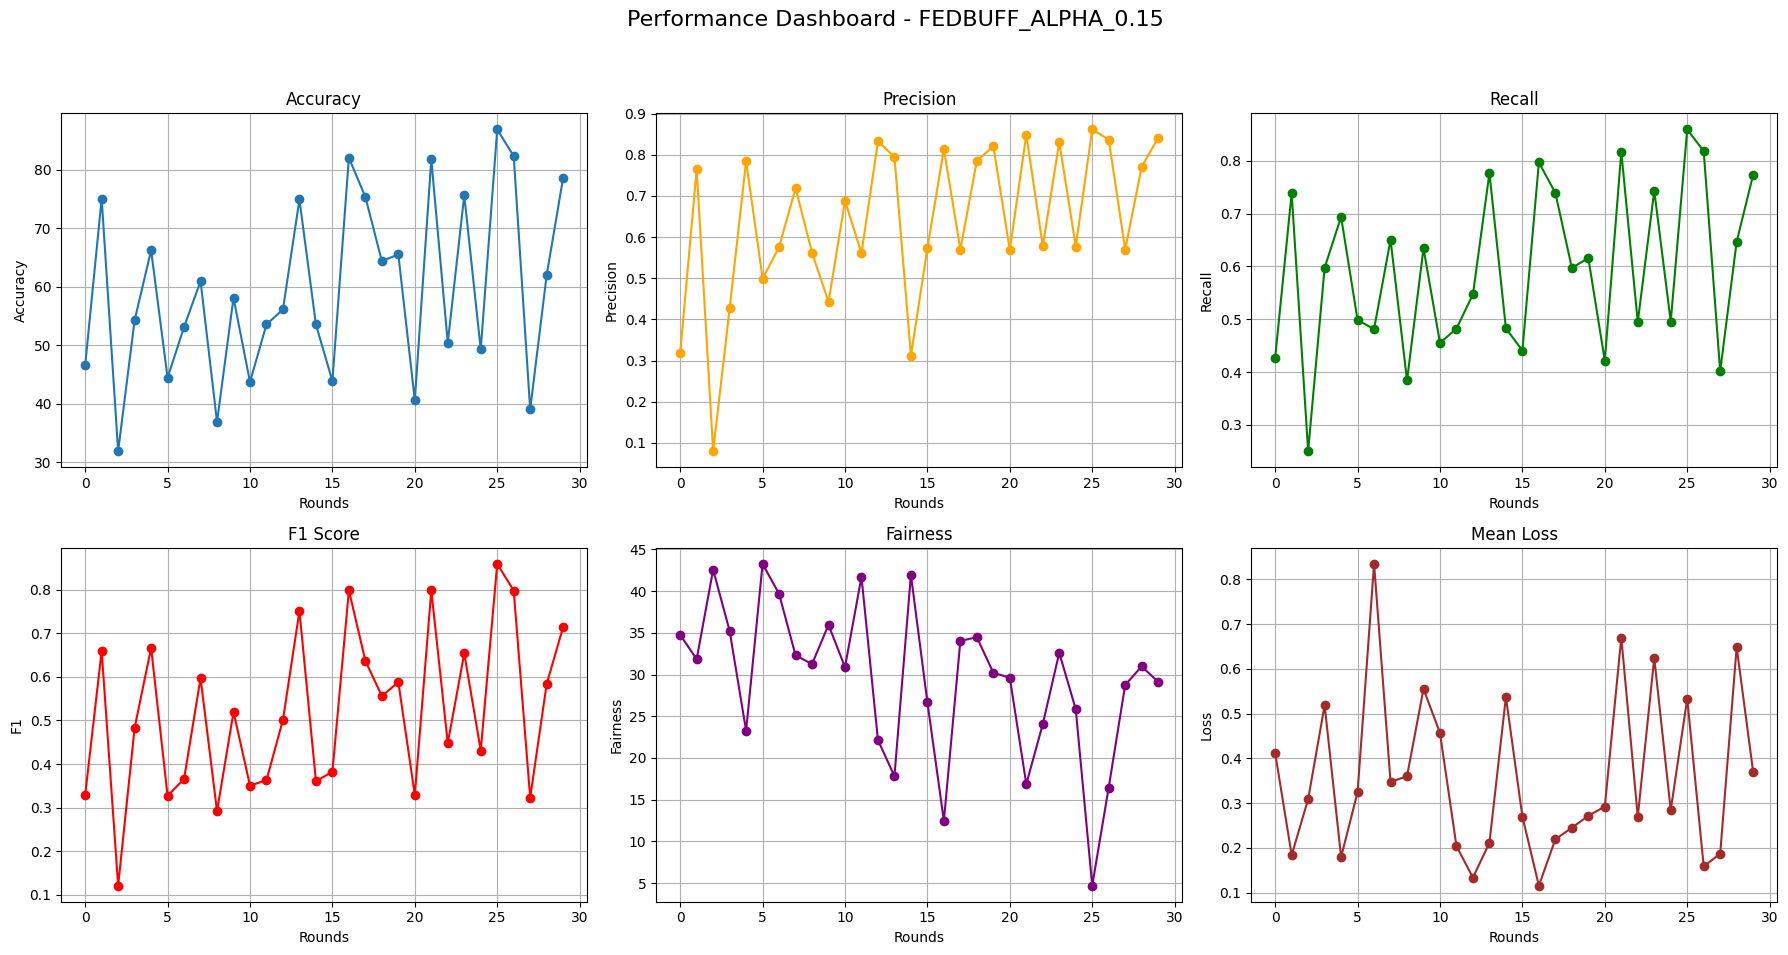

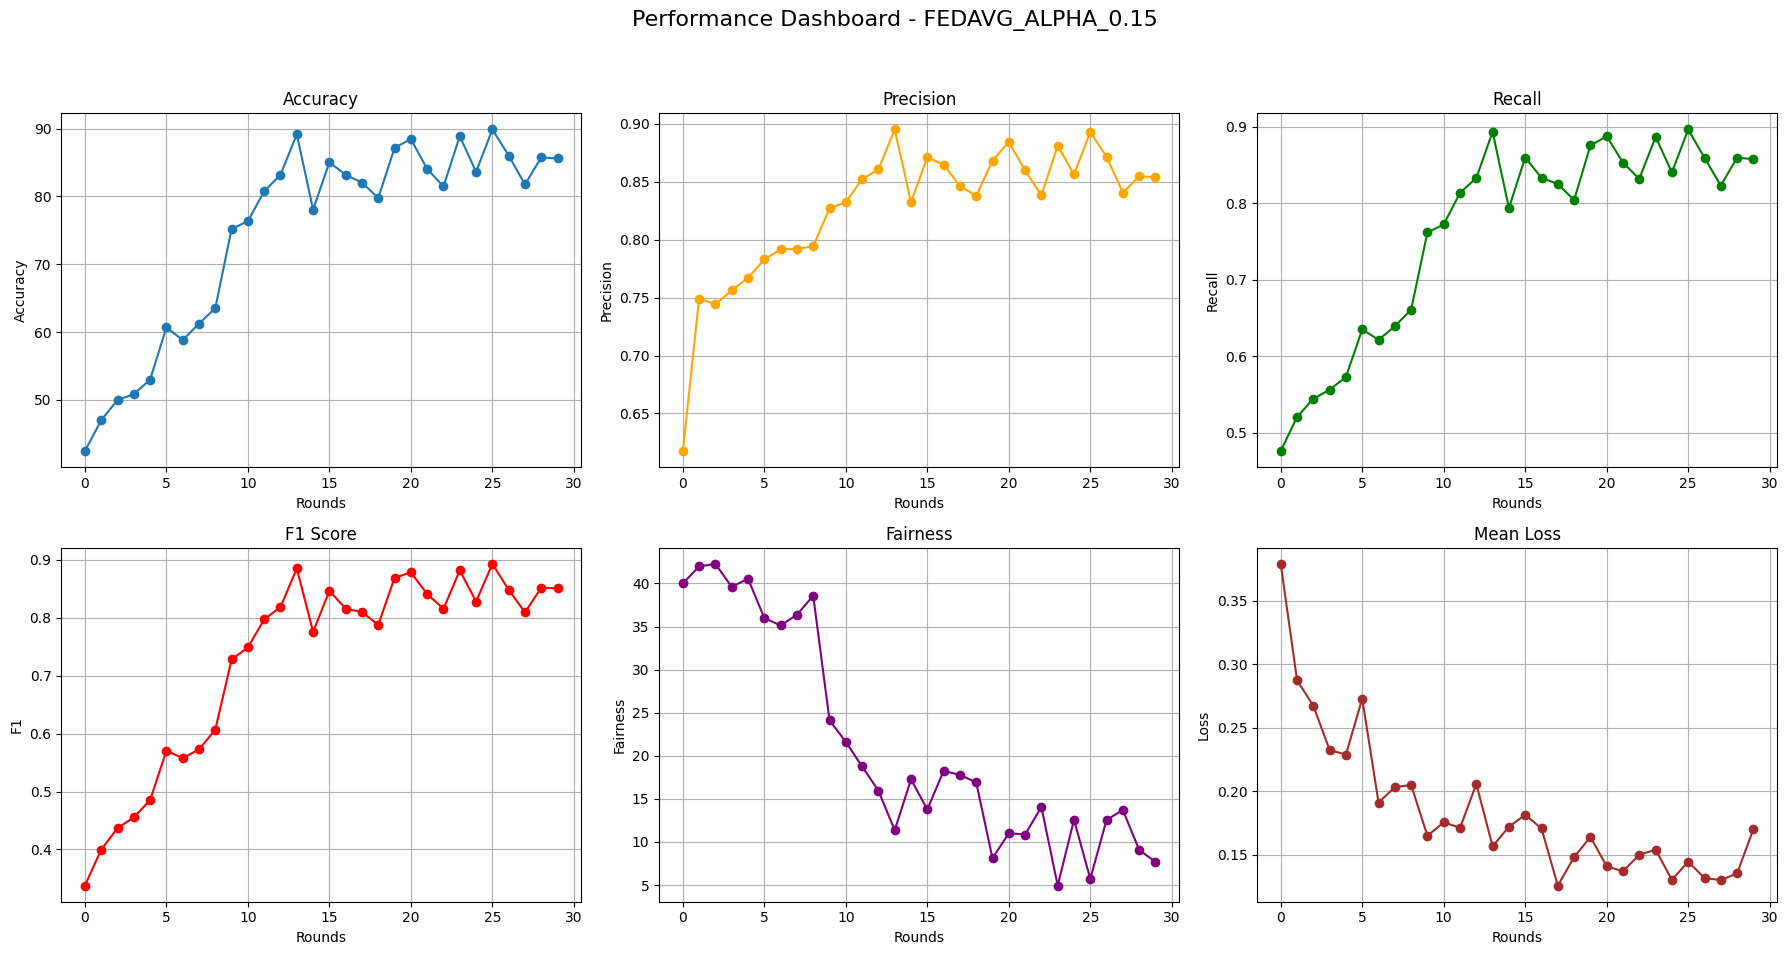

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Combined Dashboard per Method
# ------------------------------
for method, metrics in all_methods.items():
    rounds = metrics["rounds"]

    # Prepare loss (mean per round if list of client losses)
    losses = metrics["losses"]
    mean_loss = [np.mean(l) if l is not None else None for l in losses]

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"Performance Dashboard - {method}", fontsize=16)

    # Accuracy
    axs[0,0].plot(rounds, metrics["acc"], marker='o')
    axs[0,0].set_title("Accuracy")
    axs[0,0].set_xlabel("Rounds")
    axs[0,0].set_ylabel("Accuracy")
    axs[0,0].grid(True)

    # Precision
    axs[0,1].plot(rounds, metrics["prec"], marker='o', color='orange')
    axs[0,1].set_title("Precision")
    axs[0,1].set_xlabel("Rounds")
    axs[0,1].set_ylabel("Precision")
    axs[0,1].grid(True)

    # Recall
    axs[0,2].plot(rounds, metrics["rec"], marker='o', color='green')
    axs[0,2].set_title("Recall")
    axs[0,2].set_xlabel("Rounds")
    axs[0,2].set_ylabel("Recall")
    axs[0,2].grid(True)

    # F1 Score
    axs[1,0].plot(rounds, metrics["f1"], marker='o', color='red')
    axs[1,0].set_title("F1 Score")
    axs[1,0].set_xlabel("Rounds")
    axs[1,0].set_ylabel("F1")
    axs[1,0].grid(True)

    # Fairness
    axs[1,1].plot(rounds, metrics["fairness"], marker='o', color='purple')
    axs[1,1].set_title("Fairness")
    axs[1,1].set_xlabel("Rounds")
    axs[1,1].set_ylabel("Fairness")
    axs[1,1].grid(True)

    # Loss
    axs[1,2].plot(rounds, mean_loss, marker='o', color='brown')
    axs[1,2].set_title("Mean Loss")
    axs[1,2].set_xlabel("Rounds")
    axs[1,2].set_ylabel("Loss")
    axs[1,2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
